# Valeria Card Kingdoms:
## Finding an edge

This notebook has companion blog posts at scibbatical.wordpress.com:
* [Part 1](https://scibbatical.wordpress.com/2019/12/02/gamers-edge/)
* [Part 2](https://scibbatical.wordpress.com/2019/12/02/gamers-edge-ii/).

As a Duke of Valeria, you amass a population of citizens. Each citizen produces resources when their card is activated. Activation is determined by dice roll.

This game uses 2 dice to randomize citizen activation, but the mechanics are slightly different than other dice games. Like other games, the dice are rolled, and the sum of the dice dictate which resources are allocated, but in addition, the value shown on each die also triggers resource generation.

Complicating matters further, some outcomes are triggered by a roll of multiple numbers. 

This unusual mechanism alters the familiar bell curve of probability. Just how much more likely is it to roll a 4 relative to an 8 in this new system? Let's find out!

### Determine the roll probabilities
We'll perform a simulation to determine the probabilities: roll 2 dice 100 000 times and tally the results along the way. If our number of simulations is sufficiently large, the outcome should be pretty accurate.

Text(0.5,1,'Roll Activation Probabilities')

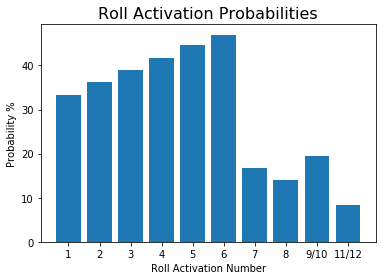

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Define an empty array to tally the frequency of each dice roll
freqs = np.zeros((13))

# Simulate 100 000 rolls
for i in range(100000):
    # Randomly generate a value for each die (two dice are used)
    a,b = np.random.randint(1,7,2)
    # Increase the tally by 1 for the result of each die, and
    # for the sum of the die values
    freqs[a] += 1
    freqs[b] += 1
    freqs[a+b] += 1
    
# The game combines roll values (9, 10), and (11, 12).
# Make sure our frequencies follow suit.
freqs_final = np.append(freqs[1:9], freqs[9]+freqs[10])
freqs_final = np.append(freqs_final, freqs[11]+freqs[12])

# Calculate the probability for a given roll:
roll_probs = freqs_final/100000


#Prepare a chart showing the frequency of each roll

# Create an x-axis and x labels
x=(1,2,3,4,5,6,7,8,9,10)
xlabels=(1,2,3,4,5,6,7,8,'9/10','11/12')

# Plot the chart
plt.bar(x,roll_probs*100)
plt.xticks(x, xlabels)
plt.ylabel('Probability %')
plt.xlabel('Roll Activation Number')
plt.title('Roll Activation Probabilities', fontsize=16)

It's clear that this probability distribution is quite different that the one normally associated with dice. So how much more likely is a 4 than an 8?

In [2]:
round(roll_probs[3]/roll_probs[7],5)

2.9896

And there you have it: you're about 3 times more likely to roll a 4 than an 8.

### Factor in the rewards

The game designers recognized that some cards were more likely to be activated, and modified each card's resource reward to approximately account for this.

To add complexity, a citizen card awards you resources depending on who rolls the dice (you or your opponent) - rewards tend to be higher on your own turn.

In addition, each citizen has a cost associated with it.


To keep track of the attributes for each card, I want to define a card _object_ that has name, cost, and reward characteristics.

In [3]:
class Card:
    
    instances = []
    
    def __init__(self, name, roll, probability, cost, prime_reward, reward):
        # The basics
        self.name = name
        self.roll = roll
        self.probability = probability
        self.cost = cost
        self.prime_reward = prime_reward
        self.reward = reward
        
        # The calculated
        self.probability_times_prime_reward = probability * prime_reward
        self.probability_times_reward = probability * reward
        
        # Add self to list of objects
        self.instances.append(self)
        

Define the Citizen cards. They are ordered from lowest roll activation to highest. Note that most roll values are associated to two cards.

In [4]:
cleric = Card("Cleric", 1, roll_probs[1-1], 3, 3, 1)
monk = Card("Monk", 1, roll_probs[1-1], 3, 3, 1)
merchant = Card("Merchant", 2, roll_probs[2-1], 2, 2, 1)
blacksmith = Card("Blacksmith", 2, roll_probs[2-1], 3, 2, 1) # assume two warrior cards on prime roll
mercenary = Card("Mercenary", 3, roll_probs[3-1], 3, 2, 1)
alchemist = Card("Alchemist", 3, roll_probs[3-1], 3, 2, 1)
archer = Card("Archer", 4, roll_probs[4-1], 4, 2, 1)
wizard = Card("Wizard", 4, roll_probs[4-1], 4, 2, 1)
peasant = Card("Peasant", 5, roll_probs[5-1], 2, 1, 1)
knight = Card("Knight", 6, roll_probs[6-1], 2, 1, 1)
rogue = Card("Rogue", 7, roll_probs[7-1], 2, 4, 2)
thief = Card("Thief", 7, roll_probs[7-1], 2, 3, 2)
champion = Card("Champion", 8, roll_probs[8-1], 2, 4, 3)
warlord = Card("Warlord", 8, roll_probs[8-1], 3, 4, 3) # assume four total warrior cards on prime roll, three soldiers on regular roll
paladin = Card("Paladin", 9, roll_probs[9-1], 2, 3, 2)
priestess = Card("Priestess", 9, roll_probs[9-1], 2, 3, 2)
butcher = Card("Butcher", 11, roll_probs[11-1-1], 1, 4, 4) # assume two total labourer cards on prime roll
miner = Card("Miner", 11, roll_probs[11-1-1], 1, 4, 4) # assume three domains on prime roll

# Create a "deck" of Citizen cards
deck = Card.instances

We're going to look at some plots, so it might be handy to define a function to generate a them. The plot displays the variation of a given relation for all cards

In [5]:
def rel_plot(deck, attribute):
    # attribute is a string, leave out the "."
    
    # Generate x-axis and labels
    x=range(len(deck))
    xlabels = []
    for card in deck:
        if card.roll == 9:
            xlabels.append(card.name + ' [9/10]')
        elif card.roll == 11:
            xlabels.append(card.name + ' [11/12]')
        else:
            xlabels.append(card.name + ' [' + str(card.roll) + ']')
    
    # Generate y-axis
    y = []
    for card in deck:
        y.append(eval(str(card.name).lower()+'.'+attribute))
        
 
    # Plot the chart
    plt.bar(x,y)
    plt.xticks(x, xlabels, rotation='vertical')
    plt.xlabel('Card [Activation Number]')
    plt.grid(True, axis='y')

    
    if attribute == "probability_times_prime_reward":
        plt.ylim(0,1.1)
        plt.ylabel('Probability * Reward')
        plt.title('Probability * Prime Reward', fontsize=16)
        
    if attribute == "probability_times_reward":
        plt.ylim(0,1.1)
        plt.ylabel('Probability * Reward')
        plt.title('Probability * Reward', fontsize=16)

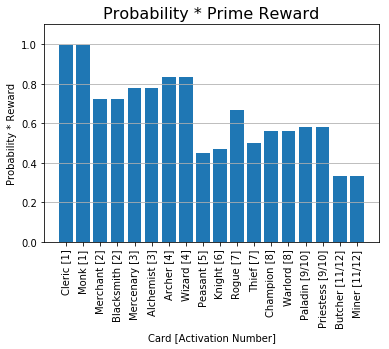

In [6]:
rel_plot(deck, "probability_times_prime_reward")

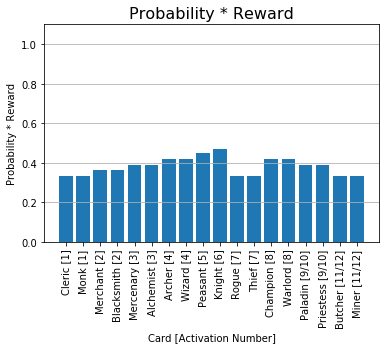

In [7]:
rel_plot(deck, "probability_times_reward")

Let's look at the relative probability times reward for prime and regular rewards

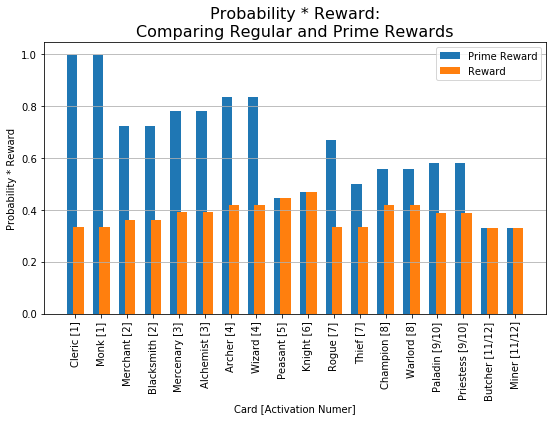

In [15]:
# Generate x-axis and labels
x=np.arange(0,2*len(deck),2)
xlabels = []
for card in deck:
    if card.roll == 9:
        xlabels.append(card.name + ' [9/10]')
    elif card.roll == 11:
        xlabels.append(card.name + ' [11/12]')
    else:
        xlabels.append(card.name + ' [' + str(card.roll) + ']')
        
# Generate y-axis
y1 = []
for card in deck:
    y1.append(card.probability_times_prime_reward)
    
y2 = []
for card in deck:
    y2.append(card.probability_times_reward)


# Plot the chart

fig = plt.figure(figsize=(9, 5))    

plt.bar(x-0.25,y1,label='Prime Reward')
plt.bar(x+0.25,y2,label='Reward')
plt.xticks(x, xlabels, rotation='vertical')
plt.ylabel('Probability * Reward')
plt.xlabel('Card [Activation Numer]')
plt.title('Probability * Reward:\nComparing Regular and Prime Rewards', fontsize=16)
plt.grid(True, axis='y')
plt.legend()

There's a trend: prime rewards are clearly better than regular ones. You can determine the  overall probability-reward relationship, but that will depend on the proportion of prime rewards to regular ones, which is dependant on the number of players. The game can be played by 2-5 players. Let's calculate the probability-reward relationships for each of those. BUT, don't forget that the regular to prime reward ratio for a 5-player game will match the 4-player variant.

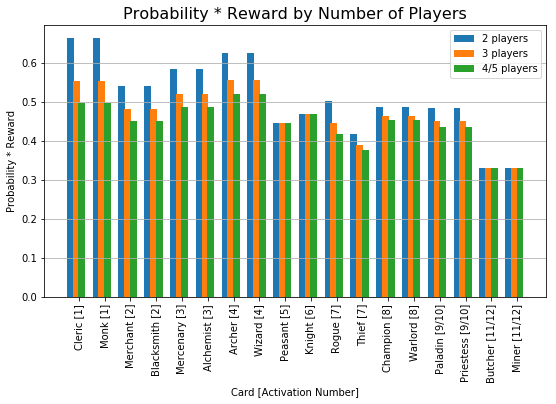

In [10]:
# Generate x-axis and labels
x=np.arange(0,3*len(deck),3)
xlabels = []
for card in deck:
    if card.roll == 9:
            xlabels.append(card.name + ' [9/10]')
    elif card.roll == 11:
            xlabels.append(card.name + ' [11/12]')
    else:
        xlabels.append(card.name + ' [' + str(card.roll) + ']')   

# Generate y-axis
y1 = []
for card in deck:
    y1.append(card.probability_times_prime_reward)
    
y2 = []
for card in deck:
    y2.append(card.probability_times_reward)


fig = plt.figure(figsize=(9, 5))    


# Plot the chart

for i in range(3):
    
    if i == 2:
        plt.bar(x-1+i*(2/3),np.add(np.multiply(1/(2+i),y1),np.multiply((1+i)/(2+i),y2)), label='4/5 players')
    else:
        plt.bar(x-1+i*(2/3),np.add(np.multiply(1/(2+i),y1),np.multiply((1+i)/(2+i),y2)), label='{} players'.format(str(i+2)))
    
        
    plt.xticks(x, xlabels, rotation='vertical')
plt.ylabel('Probability * Reward')
plt.xlabel('Card [Activation Number]')
plt.title('Probability * Reward by Number of Players', fontsize=16)
plt.grid(True, axis='y')
plt.legend()

Observations:
* The relatively poor probabilities associated with rolls 7 or higher are effectively counteracted by the enhanced resource rewards they offer.
* It's apparent that cards with a nice prime reward are advantageous when there are a few players, but this advantage is reduced with additional players.
* Cards that can be activated with a single die provide a very good Probability x Reward with two players, but this advantage disappears as more players participate.
* Cards that activate on 1 or 4 offer the best Probability x Reward... no wonder these are the most expensive cards!


### An interactive widget

_The widget won't work when viewed in GitHub. You'll need to run it locally or have a look at this [Tableau viz](https://public.tableau.com/profile/elwyn.galloway#!/vizhome/ValeriaCardKingdoms/Dashboard1)

Let's build a widget where the probability * reward plots are shown for a specified number of players. First write the plot as a function:

In [11]:
def probreward_by_players(number_of_players):
    # Generate x-axis and labels
    x=np.arange(0,len(deck))
    xlabels = []
    for card in deck:
        if card.roll == 9:
            xlabels.append(card.name + ' [9/10]')
        elif card.roll == 11:
            xlabels.append(card.name + ' [11/12]')
        else:
            xlabels.append(card.name + ' [' + str(card.roll) + ']')  

    # Generate y-axis
    y1 = []
    for card in deck:
        y1.append(card.probability_times_prime_reward)

    y2 = []
    for card in deck:
        y2.append(card.probability_times_reward)


    fig = plt.figure(figsize=(9, 5))    

    
    # Plot the chart
    
    plt.title(str(number_of_players) + ' Players: Probability * Reward', fontsize=16)
    
    if number_of_players == 5:
        number_of_players -= 1
        plt.title(str(number_of_players+1) + ' Players: Probability * Reward', fontsize=16)

    plt.bar(x,np.add(np.multiply(1/(number_of_players),y1),
                     np.multiply((number_of_players-1)/number_of_players,y2)))
    
    plt.xticks(x, xlabels, rotation='vertical')
    plt.yticks(np.arange(0,0.8,0.1))
    plt.ylabel('Probability * Reward')
    plt.xlabel('Card [Activation Number]')
    plt.grid(True, axis='y')

In [12]:
from ipywidgets import interact, interactive, interact_manual, FloatSlider, IntSlider, fixed
import ipywidgets as widgets
from IPython.display import display

In [13]:
rslt = interactive(probreward_by_players, number_of_players=IntSlider(min=2, max=5, step=1, value = 3, continuous_update=True))

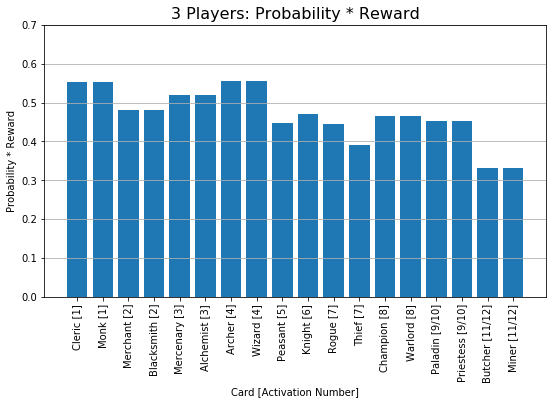

In [14]:
display(rslt)

Notice that Thief appears to have one of the worst Probability * Reward values. Consider that the Thief's Reward is taken from another player, and there are a couple of implications:
* on some turns, there are no resources to be stolen, so the average Reward is actually less than the value used for calculation
* the Reward actually _decreases_ an opponent's resources, thus the _relative_ reward is actually more than the value used for calculation

I suspect that if these two opposing factors were accounted for in the Theif's Probability * Reward calculation, it's value would be similar to its peers.

### Prepare Probability * Reward data for Tableau

I'd like to replicate the interactive Probability * Reward widget in Tableau. Tableau widgets can be embedded in Wordpress*. Tableau uses data served from many places, including Google Sheets. I will create a table here that I can copy to Sheets.

_* Um... though theoretically possible, this functionality is apparently disabled for Wordpress.com sites.


In [15]:
import pandas as pd

In [32]:
# I need columns of Card, 2-player, 3-player, 4-player, and 5-player P*Rs

# First define card attributes (I should have done this already!)
for card in deck:
    card.play2 = (1/2*card.probability_times_prime_reward) + (1/2*card.probability_times_reward)
    card.play3 = (1/3*card.probability_times_prime_reward) + (2/3*card.probability_times_reward)
    card.play4 = (1/4*card.probability_times_prime_reward) + (3/4*card.probability_times_reward)
    card.play5 = (1/4*card.probability_times_prime_reward) + (3/4*card.probability_times_reward) # same as 4-player


# Start by creating a list
proto = []

card_idx = 0

for card in deck:
    for i in range(2,6):
        if card.roll == 9:
            proto.append([card_idx, card.name + ' [9/10]', i, eval('card.play' + str(i))])
        elif card.roll == 11:
            proto.append([card_idx, card.name + ' [9/10]', i, eval('card.play' + str(i))])
        else:
            proto.append([card_idx, card.name + ' [' + str(card.roll) + ']', i, eval('card.play' + str(i))])

    card_idx += 1

proto
        
pd.DataFrame(proto).to_csv('RS_array_alt.csv', header=False, index=False)